# Problem
    - Binary Classification problem on current status

## todo

    - find relationship between trn/tst to split trn in a specific way
    - use AUC, logloss to fit the data, use linear/nonlinear/tree/ann
    - analyze important features and visualize them (give example of best and worst person)
    - gather visual info regarding our understanding of data
    - write up report

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv('../input/train.csv')
tst = pd.read_csv('../input/test.csv')

In [3]:
print(data.shape, tst.shape)

(150000, 33) (50000, 33)


In [4]:
data.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,dti,delinq_2yrs,earliest_cr_line,inq_last_6mths,open_acc,pub_rec,revol_util,total_acc,initial_list_status,application_type
0,8557094,10309140,25000,25000,25000.0,36 months,14.30%,858.07,C,C1,...,18.86,0,May-1998,0,17,1,82.6%,42,f,INDIVIDUAL
1,37632198,40395274,14000,14000,14000.0,60 months,18.54%,359.49,E,E1,...,26.30,0,Dec-1994,0,13,0,70.3%,26,w,INDIVIDUAL
2,71757622,76943409,5000,5000,5000.0,36 months,13.67%,169.81,C,C3,...,24.12,0,Nov-2005,0,17,0,61.6%,23,w,INDIVIDUAL
3,39682046,42505863,23000,23000,23000.0,60 months,14.31%,538.78,C,C4,...,22.04,0,Nov-2003,1,9,0,75.9%,16,w,INDIVIDUAL
4,57763681,61516442,7000,7000,7000.0,36 months,14.65%,241.47,C,C5,...,23.46,0,Dec-2009,1,8,0,31.9%,15,f,INDIVIDUAL


In [5]:
for col in data.columns:
    print('# col {} | nuniq {} | uniq {}'.format(col, len(data[col].unique()), data[col].unique()))

# col id | nuniq 150000 | uniq [ 8557094 37632198 71757622 ..., 90325340 63426033 12775605]
# col member_id | nuniq 150000 | uniq [10309140 40395274 76943409 ..., 96775103 67768786 14797776]
# col loan_amnt | nuniq 1384 | uniq [25000 14000  5000 ..., 36775 32700 35500]
# col funded_amnt | nuniq 1384 | uniq [25000 14000  5000 ..., 36775 32700 35500]
# col funded_amnt_inv | nuniq 2312 | uniq [ 25000.          14000.           5000.         ...,  24461.93709614
   7356.81627359  34812.98452246]
# col term | nuniq 2 | uniq ['36 months' '60 months']
# col int_rate | nuniq 489 | uniq ['14.30%' '18.54%' '13.67%' '14.31%' '14.65%' '11.14%' '8.39%' '7.59%'
 '6.24%' '12.69%' '13.35%' '7.62%' '5.93%' '7.89%' '7.39%' '11.99%' '6.03%'
 '9.71%' '9.99%' '6.68%' '11.55%' '6.92%' '15.99%' '24.99%' '18.25%'
 '14.99%' '13.49%' '14.49%' '23.99%' '16.55%' '13.98%' '6.99%' '14.46%'
 '12.99%' '5.32%' '13.44%' '10.16%' '7.12%' '15.23%' '7.91%' '16.29%'
 '11.48%' '19.99%' '14.09%' '10.99%' '15.61%' '8.18%' '15

In [6]:
data.columns

# try understanding
# installment : monthly payment incl. interest rate
# dti : monthly debt payment / monthly income ratio excluding mortgage and LC loan
# pub_rec : financial payments not paid as agreed
# revol_util : ratio of credit line one is using
# initial_list_status : Whole loan, fraction loan (invested by one or more person)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type'],
      dtype='object')

In [4]:
tst.columns

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'url', 'desc', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_util', 'total_acc',
       'initial_list_status', 'application_type'],
      dtype='object')

In [7]:
# what are we trying to predict?
# 1. interest rate?  > how much to charge for loan?
# 2. loan amount? > how much one requests?
# 3. current status? > detect who is late?

Data is essentially a log file of user's current loan situation.

Data can be classified into
    - Identifier: id, member_id
    - Loan info : loan_amnt, funded_amnt, funded_amnt_inv, grade, sub_grade, int_rate, loan_status, purpose, title, installment, term, issue_d, url, desc, application_type
    - User info : emp_title, emp_length, home_ownership, annual_inc, verification_status, zip_code, addr_state, dti, delinq_2yrs, earliest_cr_line, inq_last_6mths, open_acc, pub_rec, revol_util, total_acc, initial_list_status
    


# histogram of loan_amnt


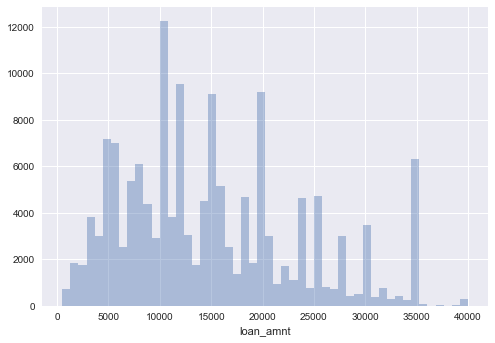

# histogram of funded_amnt


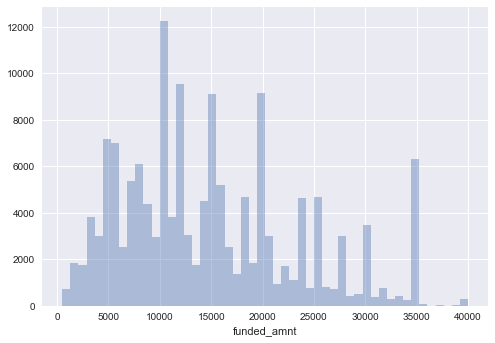

# histogram of funded_amnt_inv


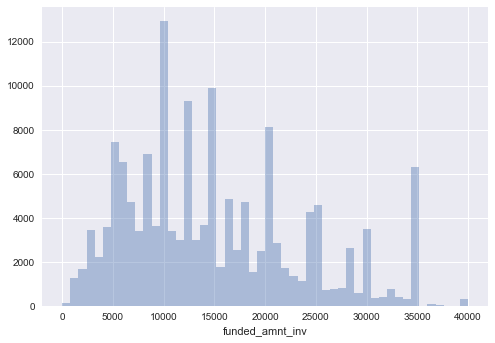

In [8]:
# histogram of loan requested, actual amount funded/invested
# expect to be almost same, turns out almost identical
cols = ['loan_amnt', 'funded_amnt', 'funded_amnt_inv']

for col in cols:
    print('# histogram of {}'.format(col))
    sns.distplot(data[col].fillna(-10), kde=False)
    plt.show()

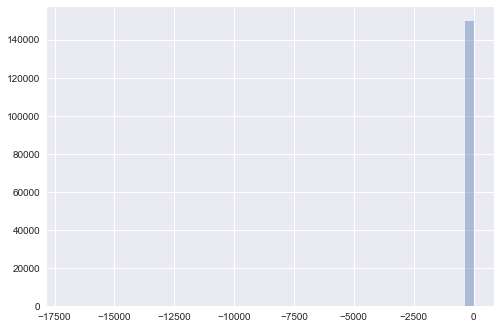

In [9]:
# difference in loan requested amount and actually funded amount
# almost close to 0 with few outliers
sns.distplot((data['funded_amnt'] - data['loan_amnt']), kde=False)

In [10]:
(data['funded_amnt'] - data['loan_amnt']).describe()

count    150000.000000
mean         -9.326667
std         266.589517
min      -16950.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           0.000000
dtype: float64

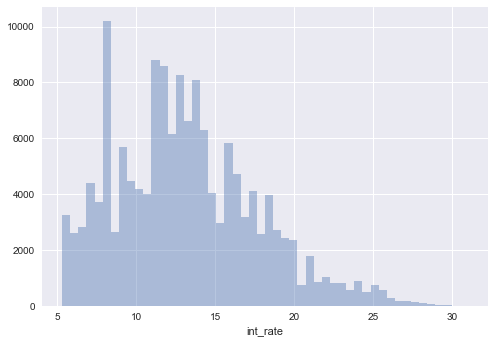

In [11]:
int_rate = data['int_rate'].apply(lambda x: x[:-1]).astype(np.float32)

# distribution of interest rate
sns.distplot(int_rate, kde=False)

# between 5 ~ 20%

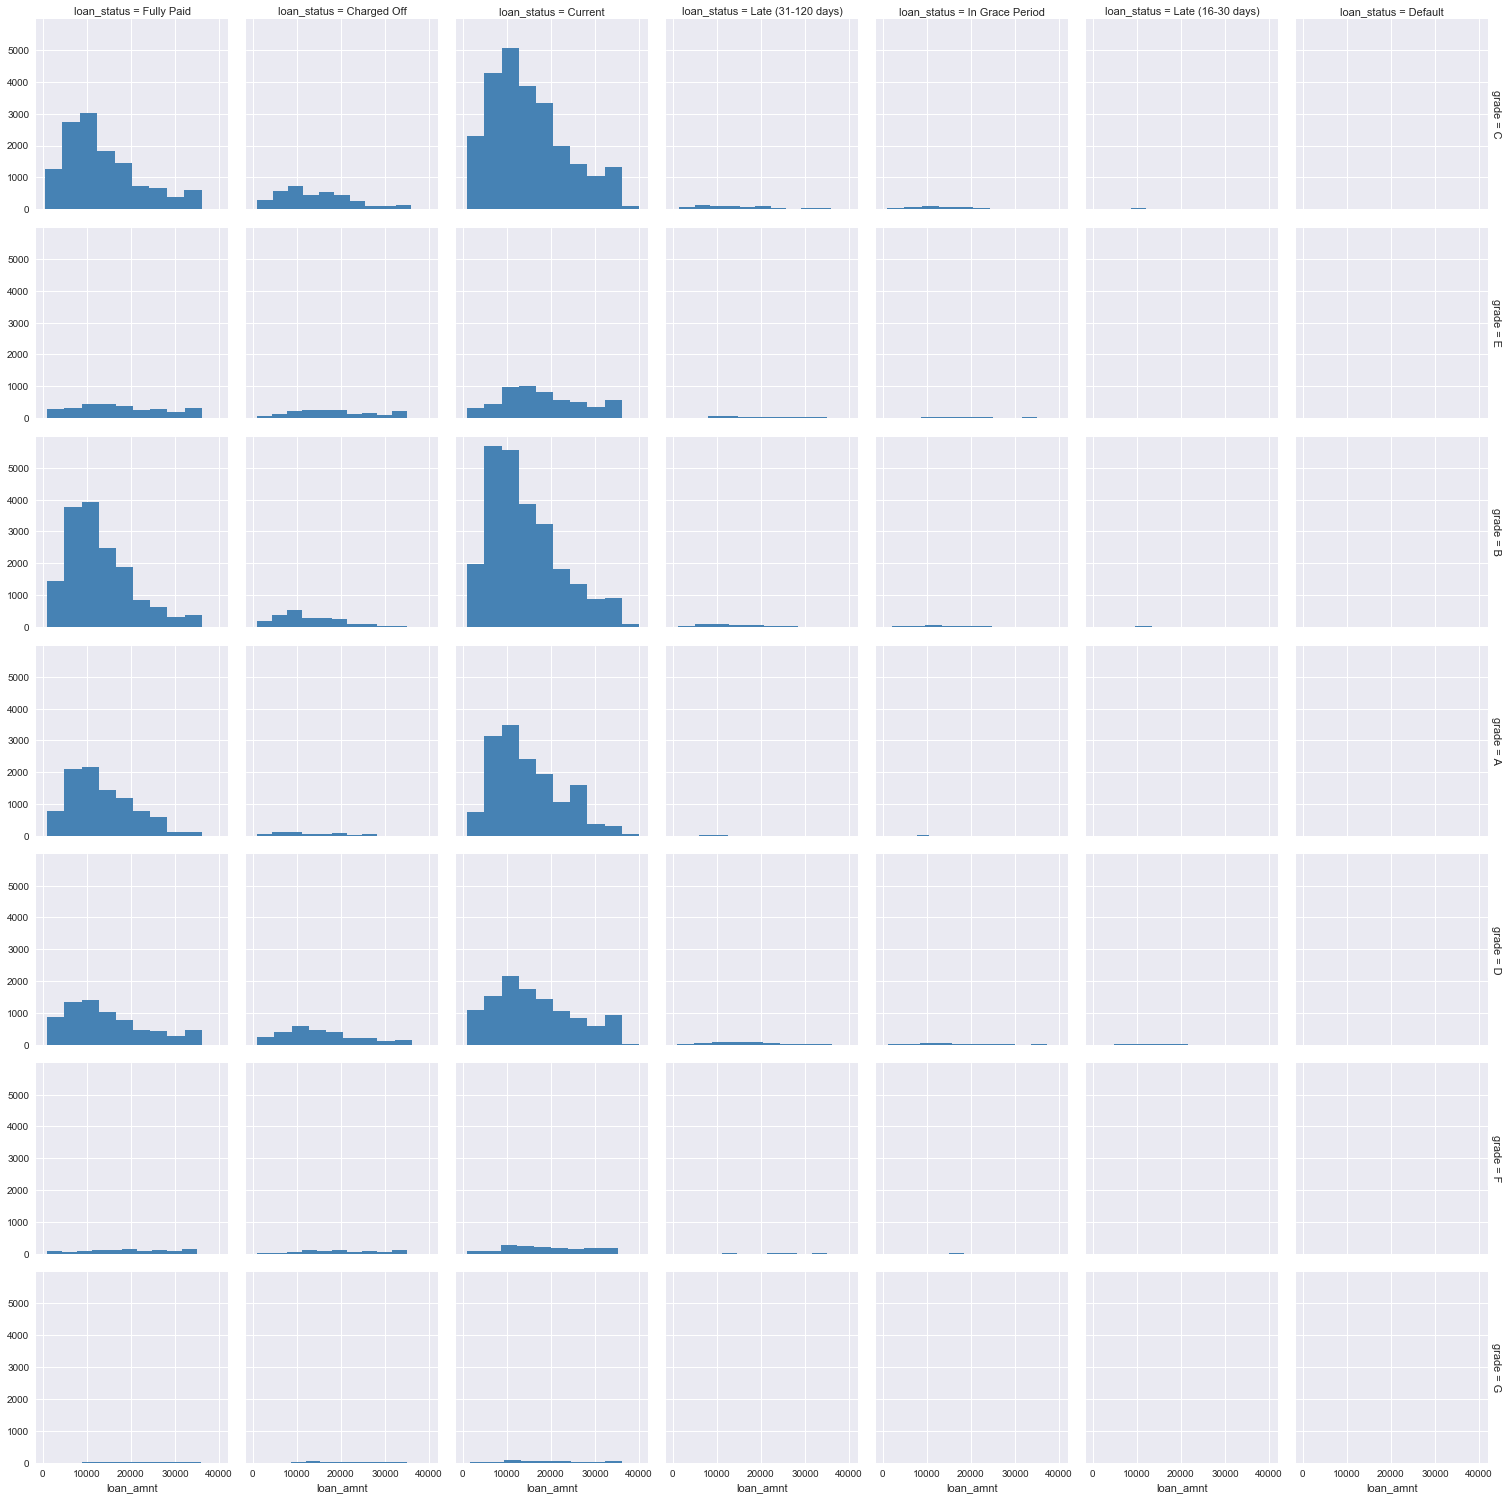

In [12]:
# Facet plot : observe how loan_status differ by their grade
# turns out: there is almost no F,G grade loaners, 
g = sns.FacetGrid(data, row='grade', col='loan_status', margin_titles=True)
g.map(plt.hist, 'loan_amnt', color='steelblue', lw=0)

count    1.500000e+05
mean     7.620913e+04
std      6.414790e+04
min      0.000000e+00
25%      4.600000e+04
50%      6.500000e+04
75%      9.000000e+04
max      8.400000e+06
Name: annual_inc, dtype: float64


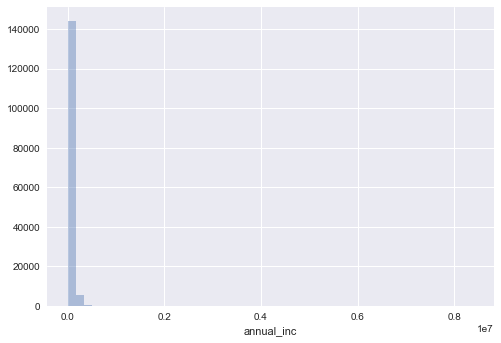

In [13]:
# check annual income
# extreme outlier with 8M.
# need to combine with verification info for reliability

print(data['annual_inc'].describe())

sns.distplot(data['annual_inc'], kde=False)

WHAT ARE WE PREDICTING?

In [14]:
# count of na

for col in data.columns:
    print('# col {} | na_count {}'.format(col, trn[col].isnull().sum()))

# col id | na_count 0
# col member_id | na_count 0
# col loan_amnt | na_count 0
# col funded_amnt | na_count 0
# col funded_amnt_inv | na_count 50
# col term | na_count 0
# col int_rate | na_count 0
# col installment | na_count 0
# col grade | na_count 0
# col sub_grade | na_count 0
# col emp_title | na_count 8949
# col emp_length | na_count 0
# col home_ownership | na_count 0
# col annual_inc | na_count 0
# col verification_status | na_count 0
# col issue_d | na_count 0
# col loan_status | na_count 0
# col url | na_count 0
# col desc | na_count 134910
# col purpose | na_count 0
# col title | na_count 2799
# col zip_code | na_count 0
# col addr_state | na_count 0
# col dti | na_count 0
# col delinq_2yrs | na_count 0
# col earliest_cr_line | na_count 0
# col inq_last_6mths | na_count 0
# col open_acc | na_count 0
# col pub_rec | na_count 0
# col revol_util | na_count 83
# col total_acc | na_count 0
# col initial_list_status | na_count 0
# col application_type | na_count 0


In [15]:
# dtype

for col in data.columns:
    print('# col {} | dtype {}'.format(col, trn[col].dtypes))

# col id | dtype int64
# col member_id | dtype int64
# col loan_amnt | dtype int64
# col funded_amnt | dtype int64
# col funded_amnt_inv | dtype float64
# col term | dtype object
# col int_rate | dtype object
# col installment | dtype float64
# col grade | dtype object
# col sub_grade | dtype object
# col emp_title | dtype object
# col emp_length | dtype object
# col home_ownership | dtype object
# col annual_inc | dtype float64
# col verification_status | dtype object
# col issue_d | dtype object
# col loan_status | dtype object
# col url | dtype object
# col desc | dtype object
# col purpose | dtype object
# col title | dtype object
# col zip_code | dtype object
# col addr_state | dtype object
# col dti | dtype float64
# col delinq_2yrs | dtype int64
# col earliest_cr_line | dtype object
# col inq_last_6mths | dtype int64
# col open_acc | dtype int64
# col pub_rec | dtype int64
# col revol_util | dtype object
# col total_acc | dtype int64
# col initial_list_status | dtype object
# co

In [19]:
# check object dtypes

for col in data.columns:
    if trn[col].dtypes == 'O':
        print('# col {} | nuniq {}'.format(col, len(trn[col].unique())))

# col term | nuniq 2
# col int_rate | nuniq 489
# col grade | nuniq 7
# col sub_grade | nuniq 35
# col emp_title | nuniq 61199
# col emp_length | nuniq 12
# col home_ownership | nuniq 5
# col verification_status | nuniq 3
# col issue_d | nuniq 111
# col loan_status | nuniq 7
# col url | nuniq 150000
# col desc | nuniq 15062
# col purpose | nuniq 14
# col title | nuniq 10081
# col zip_code | nuniq 887
# col addr_state | nuniq 51
# col earliest_cr_line | nuniq 650
# col revol_util | nuniq 1133
# col initial_list_status | nuniq 2
# col application_type | nuniq 3


In [20]:
# case study

data.iloc[0]

id                                                               8557094
member_id                                                       10309140
loan_amnt                                                          25000
funded_amnt                                                        25000
funded_amnt_inv                                                    25000
term                                                           36 months
int_rate                                                          14.30%
installment                                                       858.07
grade                                                                  C
sub_grade                                                             C1
emp_title                                               finance director
emp_length                                                     10+ years
home_ownership                                                  MORTGAGE
annual_inc                                         

# Modeling

In [47]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [98]:
cols = ['loan_amnt', 'installment', 'annual_inc', 'dti' ,'delinq_2yrs', 'inq_last_6mths', 'open_acc',
        'pub_rec', 'total_acc']

In [7]:
trn = data.as_matrix(columns=cols)
y = int_rate

NameError: name 'cols' is not defined

In [104]:
def mean_n_std(df):
    return '{} + {}'.format(round(np.mean(df),4), round(np.std(df),4))

In [113]:
trn_rmse = []; vld_rmse = []
trn_mae = []; vld_mae = []
trn_r2 = []; vld_r2 = []
trn_corr = []; vld_corr = []

skf = StratifiedKFold(n_splits=3)
for trn_index, vld_index in skf.split(trn, y):
    
    # split data into trn/vld
    x_trn, x_vld = trn[trn_index], trn[vld_index]
    y_trn, y_vld = y[trn_index], y[vld_index]
    
    # model fit
    model = RandomForestRegressor(max_depth=50, 
                                  n_jobs=-1, random_state=777)
    model.fit(x_trn, y_trn)

    # trn scores
    trn_pred = model.predict(x_trn)
    trn_rmse.append(mean_squared_error(y_trn, trn_pred))
    trn_mae.append(mean_absolute_error(y_trn, trn_pred))
    trn_r2.append(r2_score(y_trn, trn_pred))
    trn_corr.append(np.corrcoef(y_trn, trn_pred)[0,1])
    
    # vld scores
    vld_pred = model.predict(x_vld)
    vld_rmse.append(mean_squared_error(y_vld, vld_pred))
    vld_mae.append(mean_absolute_error(y_vld, vld_pred))
    vld_r2.append(r2_score(y_vld, vld_pred))
    vld_corr.append(np.corrcoef(y_vld, vld_pred)[0,1])
    
print('=' * 50)
print(' TRAIN')
print('-' * 50)
print('# CV RMSE : {}'.format(mean_n_std(trn_rmse)))
print('# CV MAE  : {}'.format(mean_n_std(trn_mae)))
print('# CV R2   : {}'.format(mean_n_std(trn_r2)))
print('# CV Corr : {}'.format(mean_n_std(trn_corr)))

print('=' * 50)
print(' VALID')
print('-' * 50)
print('# CV RMSE : {}'.format(mean_n_std(vld_rmse)))
print('# CV MAE  : {}'.format(mean_n_std(vld_mae)))
print('# CV R2   : {}'.format(mean_n_std(vld_r2)))
print('# CV Corr : {}'.format(mean_n_std(vld_corr)))

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/model_selection/_split.py:581: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of groups for any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


 TRAIN
--------------------------------------------------
# CV RMSE : 1.0074 + 0.0212
# CV MAE  : 0.5092 + 0.0151
# CV R2   : 0.9512 + 0.0011
# CV Corr : 0.978 + 0.0004
 VALID
--------------------------------------------------
# CV RMSE : 5.2701 + 0.1381
# CV MAE  : 1.2348 + 0.0429
# CV R2   : 0.7445 + 0.006
# CV Corr : 0.8658 + 0.0029


In [ ]:
# 3-fold CV [RMSE]
# depth =  5 | trn 17.33 | vld 17.43
# depth = 10 | trn 12.12 | vld 13.02 
# depth = 15 | trn 5.17  | vld 7.95 
# depth = 20 | trn 1.83  | vld 5.77
# depth = 25 | trn 1.11  | vld 5.34
# depth = 30 | trn 1.01  | vld 5.28
# depth = 50 | trn 1.00  | vld 5.27

In [120]:
for i, col in enumerate(cols):
    print('# col {} | val {}'.format(cols[i], trn[0][i]))
    
print('\n# True : {} | Pred : {}'.format(y[0], model.predict(trn[0])[0]))

# col loan_amnt | val 25000.0
# col installment | val 858.07
# col annual_inc | val 125000.0
# col dti | val 18.86
# col delinq_2yrs | val 0.0
# col inq_last_6mths | val 0.0
# col open_acc | val 17.0
# col pub_rec | val 1.0
# col total_acc | val 42.0

# True : 14.300000190734863 | Pred : 13.532000064849854


/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/sklearn/utils/validation.py:395: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


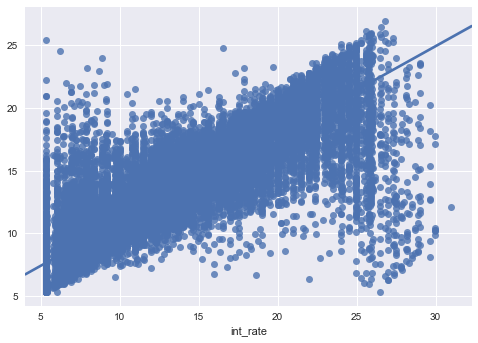

In [122]:
sns.regplot(y_vld, vld_pred)

# visualization

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=50,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=777,
           verbose=0, warm_start=False)
--------------------------------------------------
# Sorted Feature Importance
     0.40664 	 installment
     0.31227 	 loan_amnt
     0.07251 	 annual_inc
     0.07236 	 dti
     0.05231 	 inq_last_6mths
     0.03898 	 total_acc
     0.02694 	 open_acc
     0.00964 	 delinq_2yrs
     0.00835 	 pub_rec


[<matplotlib.text.Text at 0x116bc4160>, <matplotlib.text.Text at 0x116138b00>]

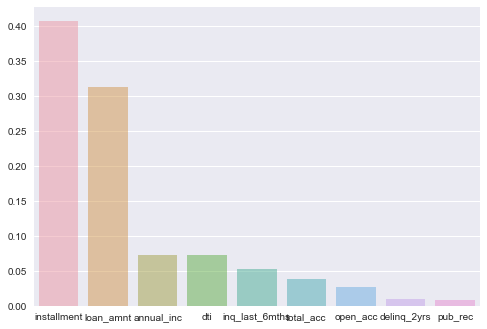

In [114]:
import operator

print('='*50)
print(model)

feature_importance = dict()
for i, f_imp in enumerate(model.feature_importances_):
    feature_importance[cols[i]] = f_imp

print('-'*50)
print('# Sorted Feature Importance')
feature_importance_sorted = sorted(feature_importance.items(), key=operator.itemgetter(1), reverse=True)
for item in feature_importance_sorted:
    print('{} {} \t {}'.format(prefix, round(item[1],5), item[0]))

# plot
fimp = feature_importance_sorted
plot_x = []; plot_y = []
for item in fimp:
    plot_x.append(item[0])
    plot_y.append(item[1])

#f, ax = plt.subplots(figsize=(20, 15))
sns.barplot(plot_x,plot_y,alpha=0.5)
ax.set_title('Feature Importance for Model : Decision Tree')
ax.set(xlabel='Column Name', ylabel='Feature Importance')